# [15%] Tokenization with Neural Network

This exercise asks you to build deep learning models with Keras framework on Thai word segmenation task using NECTEC's BEST corpus.

The are the total of 7 tasks:



* [2%]Task 1: Dense layer
* [2%]Task 2: evaluation
* [2%]Task 3: Dropout
* [2%]Task 4: Implement a better model.
* [2%]Task 5: Tensorboard for model tuning
* [2%]Task 6: write code to show errors
* [3%]Task 7: Questions



We provide the code for data cleaning and some starter code for keras in this notebook but feel free to modify those parts to suit your needs.

**Don't forget to change hardware accelerator to GPU in Google Colab.**

Please submit your colab worksheet (a link to your worksheet or ipynb file) to google classroom by Jan 10, 11:59 PM Late submission will deduct 1% per day.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
tf.config.experimental.set_memory_growth(gpu_devices[0], True)
#load tensorboard
%load_ext tensorboard

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Hera is the example of thai word segmentation.
'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict and the characters that surround it (the context) as features.

In [ ]:
# Create a character map
CHARS = [
    '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
    ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
    '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
    'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
    'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
    'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
    'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
    'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
    'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
    'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
    'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
    '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

def create_n_gram_df(df, n_pad):
    """
    Given an input dataframe, create a feature dataframe of shifted characters
    Input:
    df: timeseries of size (N)
    n_pad: the number of context. For a given character at position [idx],
        character at position [idx-n_pad/2 : idx+n_pad/2] will be used
        as features for that character.

    Output:
    dataframe of size (N * n_pad) which each row contains the character,
        n_pad_2 characters to the left, and n_pad_2 characters to the right
        of that character.
    """
    n_pad_2 = int((n_pad - 1)/2)
    for i in range(n_pad_2):
        df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
        df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
    return df[n_pad_2: -n_pad_2]


def prepare_feature(best_processed_path, option='train'):
    """
    Transform the path to a directory containing processed files
    into a feature matrix and output array
    Input:
    best_processed_path: str, path to a processed version of the BEST dataset
    option: str, 'train' or 'test'
    """
    # we use padding equals 21 here to consider 10 characters to the left
    # and 10 characters to the right as features for the character in the middle
    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{'char': ' ', 'target': True}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    df = []
    # article types in BEST corpus
    article_types = ['article','encyclopedia', 'news', 'novel'] #'article','encyclopedia', 'news', 'novel'
    for article_type in article_types:
        df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))

    df = pd.concat(df)
    # pad with empty string feature at the start and the end
    df = pd.concat((df_pad, df, df_pad))

    # map characters to numbers, use 'other' if not in the predefined character set.
    df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

    # Use nearby characters as features
    df_with_context = create_n_gram_df(df, n_pad=n_pad)

    # Reorder column
    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
                ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

    # convert pandas dataframe to numpy array to feed to the model
    x_char = df_with_context[char_row].to_numpy()
    y = df_with_context['target'].astype(int).to_numpy()

    return x_char, y

In [ ]:
# Path to the preprocessed data
best_processed_path = '/content/drive/MyDrive/KMITL/NLP/colab/lab/corpora/BEST'

# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

In [ ]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[0:3])
print('First 30 class labels', y_train[:30])

#print char of feature 1
char = np.array(CHARS)

#A function for displaying our features in text
def translate_features(tfeature,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    return center + ': ' + word

for ind in range(0,3):
    word = translate_features(x_train_char,ind)
    print("{}  \t pred = {}".format(word,y_train[ind]))

First 3 features:  [[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
ค:  ค ณะตุลาการร  	 pred = 1
ณ: ค ณ ะตุลาการรั  	 pred = 0
ะ: คณ ะ ตุลาการรัฐ  	 pred = 0


Now, you are going to define the model to be used as your classifier. We encourage you to use the [Keras Funtional API](https://keras.io/guides/functional_api/) instead of the Sequential model as it is easier to create complex models (and to read your code). You can find more about Keras Functional API on Keras documentation.

You need to create a function that return a model you want and write code that invoke _**model.fit**_ to train your model. For example, your function ***get_nn()*** might looks like this:

```python
def get_nn():
  input1 = Input(...)
  ...
  # Create your wonderful model.
  ...
  out = ...
  model = Model(inputs=input1, outputs=out)
  model.compile(...)
return model
```


## Task 1: Dense layer
Create simple Dense layers **without** adding any dropout or other type of layers (e.g., LSTM, CNN). You may choose any number or parameter you want (e.g., #neuron activation function, batch size, etc.).

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime


def get_feedforward_nn():
    ###add code here ###

    #####
    model.summary()
    return model


verbose = 1
model_feedforward_nn = get_feedforward_nn()

epochs = xxx
batch_size = yyy
model_feedforward_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_char, y_val))


## Task 2: evaluation
Write a code to evaluate the result from the model that returns precision, recall, and F-score for each class (0,1).

If you use sigmoid on the last layer, when the probability is less than 0.5, it
will be class 0 and 1 when is equal to or more than 0.5.  

In [ ]:
from sklearn.metrics import classification_report

def evaluate(x_test, y_test, model):
    ###add code here ###

    #####
    return y_pred

y_pred = evaluate(x_test_char, y_test, model_feedforward_nn)


In [ ]:
evaluate(x_test_char, y_test, model_feedforward_nn)

## Task 3: Dropout

try adding dropout to the model, run, and report the result again.

In [ ]:
def get_nn_with_dropout():
    ###add code here ###

    #####
    model.summary()
    return model

print('start training')
verbose = 2

model_nn_with_dropout = get_nn_with_dropout()
model_nn_with_dropout.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_char, y_val))

In [ ]:
evaluate(x_test_char, y_test, model_nn_with_dropout)

## Task 4: Implement a better model.
Try to design and implement any model to achieve more than 95% accuracy.

Here are some ideas that work well in this task.

1.   1d-convolution neural networks with the following structure:
Input -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> TimeDistributed (Dense size 5) -> fully-connected layer (size 100) -> output.

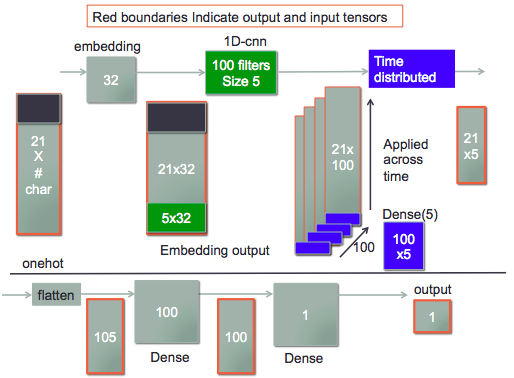

2.   GRU model with the following structure: input -> embedding layer (size 32) -> GRU layer (size 32) -> fully-connected layer (size 100) -> output.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout,Embedding,Conv1D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
# This is called to clear the original model session in order to use TensorBoard
from tensorflow.keras import backend as K
K.clear_session()

def get_nn_model():

    return model



print('start training')
verbose = 1
model_nn = get_nn_model()

epochs = xxx
batch_size = yyy
model_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(x_val_char, y_val))

In [ ]:
evaluate(x_test_char, y_test, model_nn)

## Tensorboard
The code provided also have Tensorboard (a visualization tool that comes with Tensorflow). Note the part that calls it `TensorBoard(log_dir='./Graph/' + graph_name, histogram_freq=1, write_graph=True, write_grads=True)`. This tells Tensorflow to write extra outputs to the `log_dir` which can then be used for visualization.

To start tensorboard do
```
tensorboard --logdir=/full_path_to_your_logs
```

In Tensorboard, you will be able to debug your computation graph which can be hard to keep track in code. This is might seem trivial in Keras, but it is very helpful for Tensorflow. You can see a visualization of the computation graph at the `GRAPH` tab. If you see multiple dense layers (more than 4), this is caused by running the code several times without deleting the log dir. Delete the log dir and re-run the code.

Next, let's look at the scalars tab, we can see the loss and accuracy on the training and validation set as they change over each epoch. This can be useful to detect overfitting.

Another useful tab is the histograms tab (Enable by setting 'write_grads=True'). This plot histograms of the weights, biases, and outputs of each layer. The depth of the histograms show the change over epochs. We can see how the histograms of weights change over the training peroid. This can be used to debug vanishing gradients or getting stuck in local minimas.

There are other useful tabs in Tensorboard, you can read about them in the Keras [documentation](https://keras.io/callbacks/#tensorboard) for tensorboard.

See example on how to use tensorboard for hyperparaneter tuning
* https://www.youtube.com/watch?v=lV09_8432VA&t=926s




## Task 5: Tensorboard for model tuning

Create at least **5** sets of models with different parameters (e.g., #neuron, epoch, or even different architecture). Then, train and compare each model's performance with the tensorboard.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout,Embedding,Conv1D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
# This is called to clear the original model session in order to use TensorBoard
from tensorflow.keras import backend as K
K.clear_session()


### you may change any code you want ###

#####


verbose = 1


for (epochs, batch_size) in train_params:

    ## you may change a name and a path according to your experiment
    log_dir = './Graph/model_{}epochs_{}batch_size'.format(epochs,batch_size)
    callbacks_list_feedforward_nn = [TensorBoard(log_dir= log_dir, histogram_freq=1, write_graph=True, write_grads=False)]

    model_feedforward_nn.fit(x_train_char, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                            callbacks=callbacks_list_feedforward_nn,
                            validation_data=(x_val_char, y_val))

Show the models performance on the tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='./Graph/' #remember to adjust path accordingly

## Task 6: write code to show errors
Write code to show a few of the errors the models made.

here is the example of error


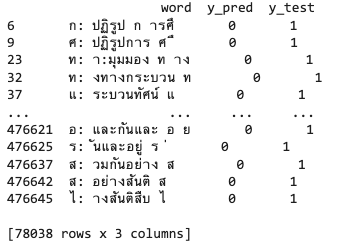

In [ ]:
 ###add code here ###


#####


## Task 7: Questions
Please write your answer here to each question. You can answer in Thai or English :)

*   Q 7.1) Does the dropout layer improve the model performance? Why?

*   Q 7.2) What is the suitable neural network layer (Eg. dense, LSTM, ..., etc) on the word-segmentation task? What is the reason behind it?

*   Q 7.3) Apart from hyperparameter tuning, neural network design, and architecture, what else can we do to improve the task accuracy? to create a better model?